# USDM & SPI - Pixel Comparison

a. stein 6.2.2022

Instead of aggregating into area fractions, this notebook aims to do a pixel resolution comparison between USDM and SPI.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot

Populating the interactive namespace from numpy and matplotlib


/pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

spi_intervals = ['14d', '30d', '90d', '180d', '270d', '1y', '2y', '5y', ]
cats = ['neutral_wet', 'D0', 'D1', 'D2', 'D3', 'D4']

dm_vars = ['USDM']
dm_vars.extend([f'spi_{interval}' for interval in spi_intervals])

paired_ds = xr.open_dataset(f'{dm_path}/ndrought_products/paired_USDM_SPI.nc')

In [3]:
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 ...
    USDM         (index, lat, lon) float64 ...
    USDM Date    (index) datetime64[ns] ...
    spi_1y       (index, lat, lon) float32 ...
    spi_2y       (index, lat, lon) float32 ...
    spi_5y       (index, lat, lon) float32 ...
    spi_14d      (index, lat, lon) float32 ...
    spi_30d      (index, lat, lon) float32 ...
    spi_90d      (index, lat, lon) float32 ...
    spi_180d     (index, lat, lon) float32 ...
    spi_270d     (index, lat, lon) float32 ...
    SPI Date     (index) datetime64[ns] ...
Attributes:
    author:       a. stein 6/8/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

In [4]:
test_pixel = paired_ds['USDM'].isel(lat=40, lon=100)

In [5]:
print(f'lat:{np.float64(test_pixel.lat.values)}, lon:{np.float64(test_pixel.lon.values)}')

lat:47.31666666666667, lon:-120.55833330000002


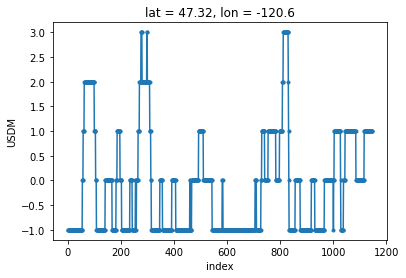

In [6]:
test_pixel.plot(marker='.')

Text(0.5, 1.0, 'lat = 47.32, lon=-120.6')

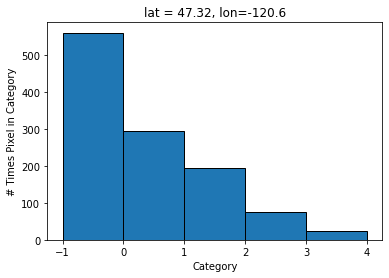

In [7]:
fig, ax = plt.subplots()

ax.hist(test_pixel,bins=[-1, 0, 1, 2, 3, 4], edgecolor='k')
ax.set_xlabel('Category')
ax.set_ylabel('# Times Pixel in Category')
ax.set_title('lat = 47.32, lon=-120.6')

In [8]:
test_ac = np.correlate(test_pixel, test_pixel, mode='full')
test_ac

array([-1., -2., -3., ..., -3., -2., -1.])

Helpful guide on what correlation is: https://www.youtube.com/watch?v=cuD-LXic2cE

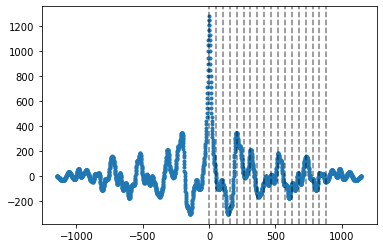

In [9]:
fig, ax = plt.subplots()

ax.plot(np.arange(-1147, 1148, 1), test_ac, marker='.', linestyle='')

# quick grid lines for each year
for i in np.arange(18):
    ax.axvline(52*i, color='k', linestyle='--', alpha=0.5)

So it looks like there is an issue with numpy doing calculations with nans ...

In [10]:
np.nan + 1

nan

Yeah alright then. Hm. I can try writing my own function to handle them now that I know more about correlation?

Actually that might be rather complicated ... let's just use the statistical correlation coefficient and impost a phase lag.

### $r = \frac{n(\sum{xy}) - (\sum{x})(\sum{y})}{\sqrt{[n\sum{x^2} - (\sum{x})^2][n\sum{y^2} - (\sum{y})^2]}}$

In [11]:
np.corrcoef(test_pixel, test_pixel)

array([[1., 1.],
       [1., 1.]])

Cool, the numpy function isn't helpful there

In [12]:
def nan_corrcoef(x, y):

    n = len(x)
    if n != len(y):
        raise Exception('x and y are not the same size')

    numer = n*np.sum(x*y) - (np.sum(x)*np.sum(y))
    denom = n*np.sum(x**2) - np.sum(x)**2
    denom *= n*np.sum(y**2) - np.sum(y)**2
    denom = np.sqrt(denom)

    return numer/denom

In [13]:
nan_corrcoef(test_pixel, test_pixel)

<xarray.DataArray 'USDM' ()>
array(1.)
Coordinates:
    lat      float64 47.32
    lon      float64 -120.6

Awesome. Dunno why the numpy function doesn't work but I'm just happy to have a function that does.

In [14]:
def lag_nan_corrcoef(x:xr.DataArray, y:xr.DataArray, lag:int, lag_step=1):

    n = len(x)
    if n != len(y):
        raise Exception('x and y are not the same size')
    if lag > n:
        raise Exception('lag cannot exceed size of x or y')
    
    r_array = []

    # check if empty pixel
    if np.all(np.isnan(x)) or np.all(np.isnan(y)):
        r_array = np.nan*np.arange(-1*lag, lag+1, 1)
    else:
        for lag_i in np.arange(-lag, 0, lag_step):
            r_array.append(nan_corrcoef(x[:lag_i], y[-1*lag_i:]).values)
        r_array.append(nan_corrcoef(x, y).values)
        for lag_i in np.arange(1, lag+1, lag_step):
            r_array.append(nan_corrcoef(x[lag_i:], y[:-1*lag_i]).values)

    return np.arange(-1*lag, lag+1, 1), np.hstack(r_array)

In [15]:
lag, r = lag_nan_corrcoef(test_pixel, test_pixel, lag=50)

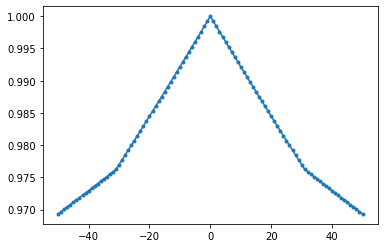

In [16]:
fig, ax = plt.subplots()

ax.plot(lag, r, marker='.')

Nice, that looks right for an autocorrelation check.

Now what if I do this between USDM and SPI?

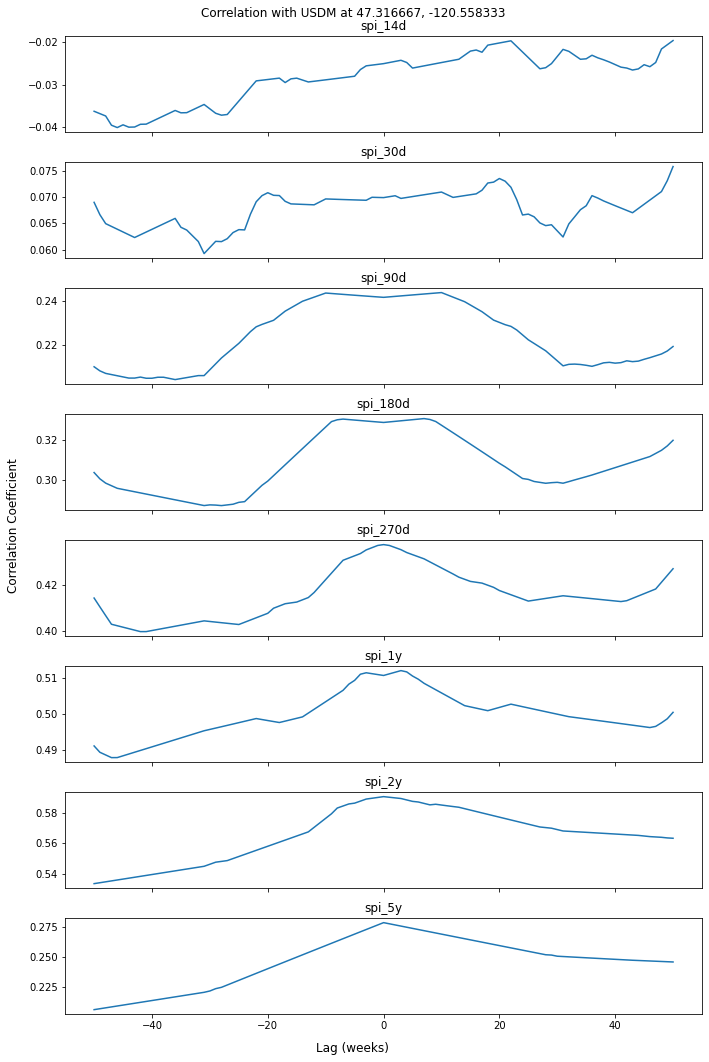

In [17]:
lat_dex = 40
lon_dex = 100

fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(10,15), sharex=True)

paired_pixel = paired_ds.isel(lat=lat_dex, lon=lon_dex)

for ax, spi_int in zip(axs.ravel(), spi_intervals):
    lag, r = lag_nan_corrcoef(paired_pixel['USDM'], paired_pixel[f'spi_{spi_int}'], lag=50)

    ax.plot(lag, r)
    ax.set_title(f'spi_{spi_int}')

fig.suptitle(f'Correlation with USDM at {np.float64(paired_pixel.lat.values):.6f}, {np.float64(paired_pixel.lon.values):.6f}')
fig.supylabel('Correlation Coefficient')
fig.supxlabel('Lag (weeks)')

plt.tight_layout()

What do those time series look like normally?

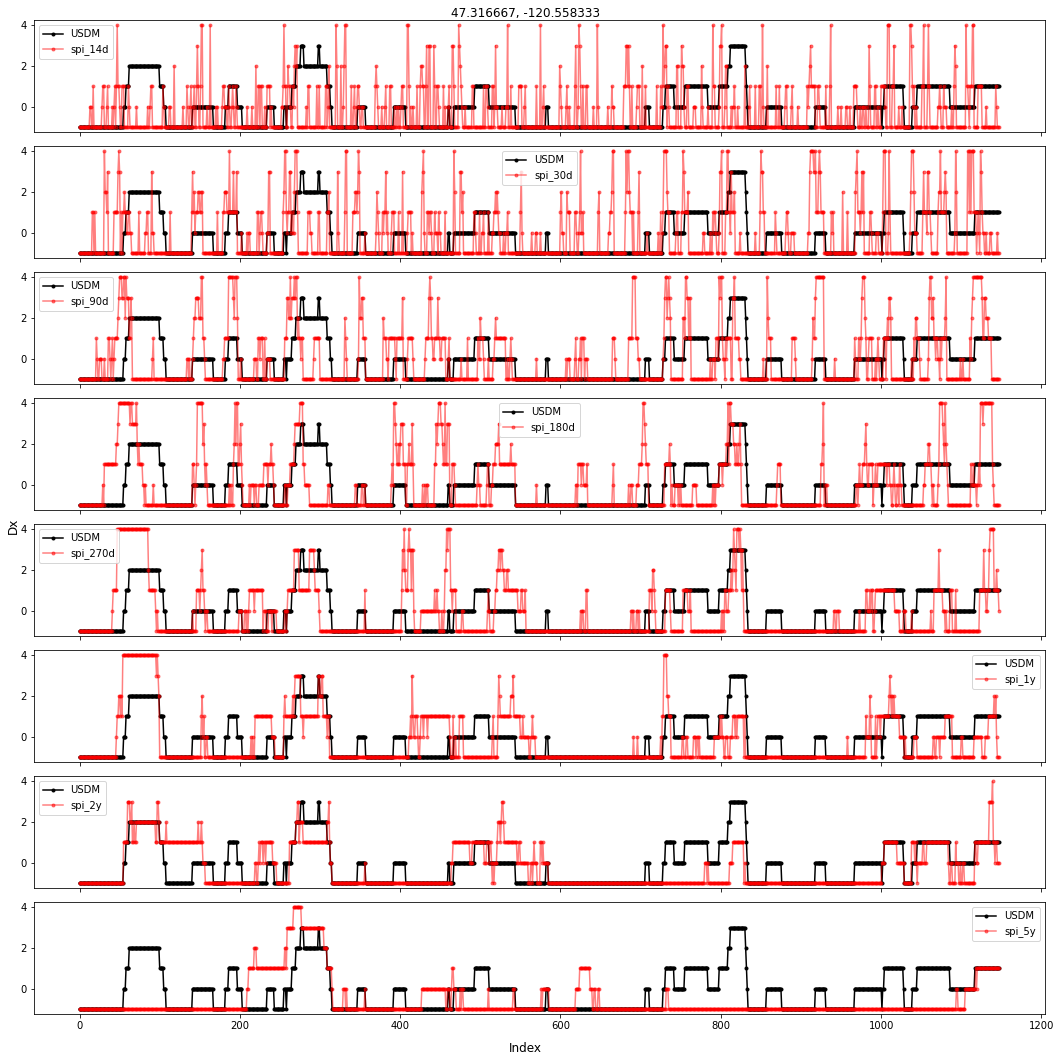

In [18]:
lat_dex = 40
lon_dex = 100

fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(15,15), sharex=True)

paired_pixel = paired_ds.isel(lat=lat_dex, lon=lon_dex)

for ax, spi_int in zip(axs.ravel(), spi_intervals):

    ax.plot(paired_pixel['USDM'], color='k', label='USDM', marker='.')
    ax.plot(paired_pixel[f'spi_{spi_int}'], color='r', label=f'spi_{spi_int}', marker='.', alpha=0.5)
    ax.legend()

fig.suptitle(f'{np.float64(paired_pixel.lat.values):.6f}, {np.float64(paired_pixel.lon.values):.6f}')
fig.supylabel('Dx')
fig.supxlabel('Index')

plt.tight_layout()

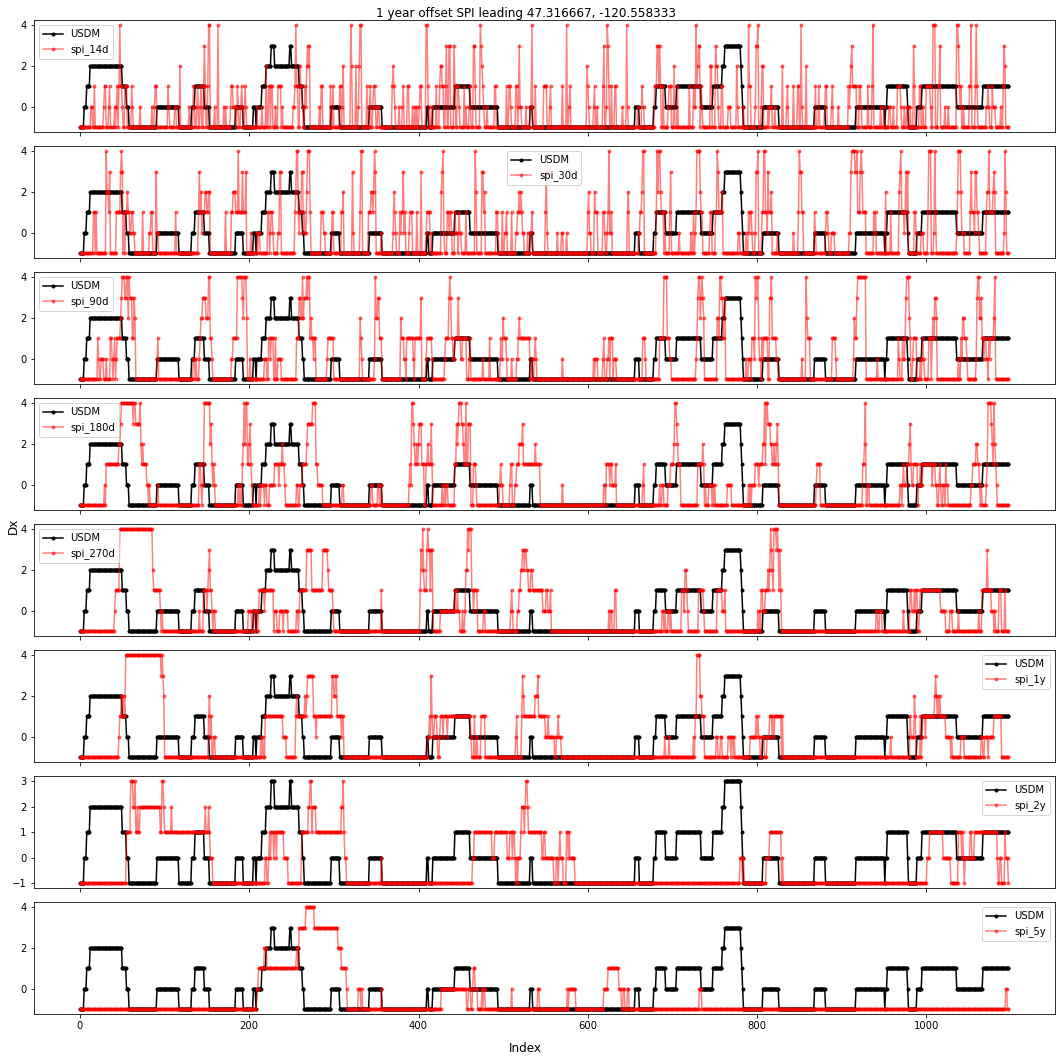

In [19]:
lat_dex = 40
lon_dex = 100

fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(15,15), sharex=True)

paired_pixel = paired_ds.isel(lat=lat_dex, lon=lon_dex)

for ax, spi_int in zip(axs.ravel(), spi_intervals):

    ax.plot(np.arange(0, 1148-50), paired_pixel['USDM'].values[50:], color='k', label='USDM', marker='.')
    ax.plot(np.arange(0, 1148-50), paired_pixel[f'spi_{spi_int}'].values[:-50], color='r', label=f'spi_{spi_int}', marker='.', alpha=0.5)
    ax.legend()

fig.suptitle(f'1 year offset SPI leading {np.float64(paired_pixel.lat.values):.6f}, {np.float64(paired_pixel.lon.values):.6f}')
fig.supylabel('Dx')
fig.supxlabel('Index')

plt.tight_layout()

Hm ... what's individual autocorrelation look like?

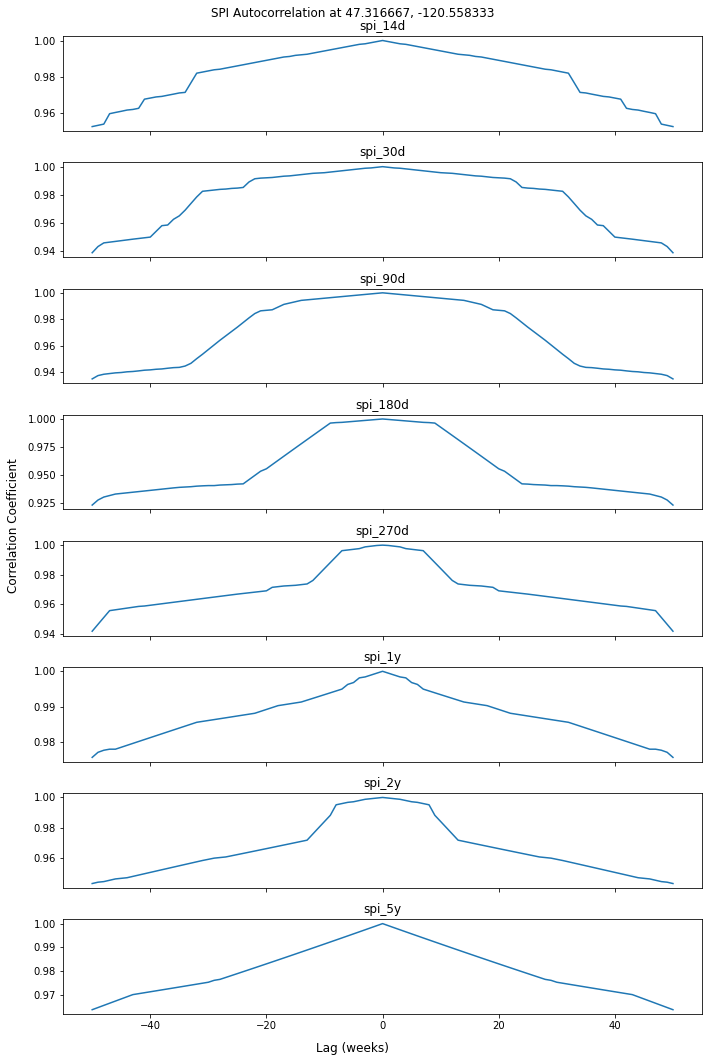

In [20]:
lat_dex = 40
lon_dex = 100

fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(10,15), sharex=True)

paired_pixel = paired_ds.isel(lat=lat_dex, lon=lon_dex)

for ax, spi_int in zip(axs.ravel(), spi_intervals):
    lag, r = lag_nan_corrcoef(paired_pixel[f'spi_{spi_int}'], paired_pixel[f'spi_{spi_int}'], lag=50)

    ax.plot(lag, r)
    ax.set_title(f'spi_{spi_int}')

fig.suptitle(f'SPI Autocorrelation at {np.float64(paired_pixel.lat.values):.6f}, {np.float64(paired_pixel.lon.values):.6f}')
fig.supylabel('Correlation Coefficient')
fig.supxlabel('Lag (weeks)')

plt.tight_layout()

I wonder if the high autocorrelation is messing things up. What if I only do when it's in a drought, e.g. D1 or greater?

In [21]:
usdm_dates = paired_pixel['USDM Date'].values

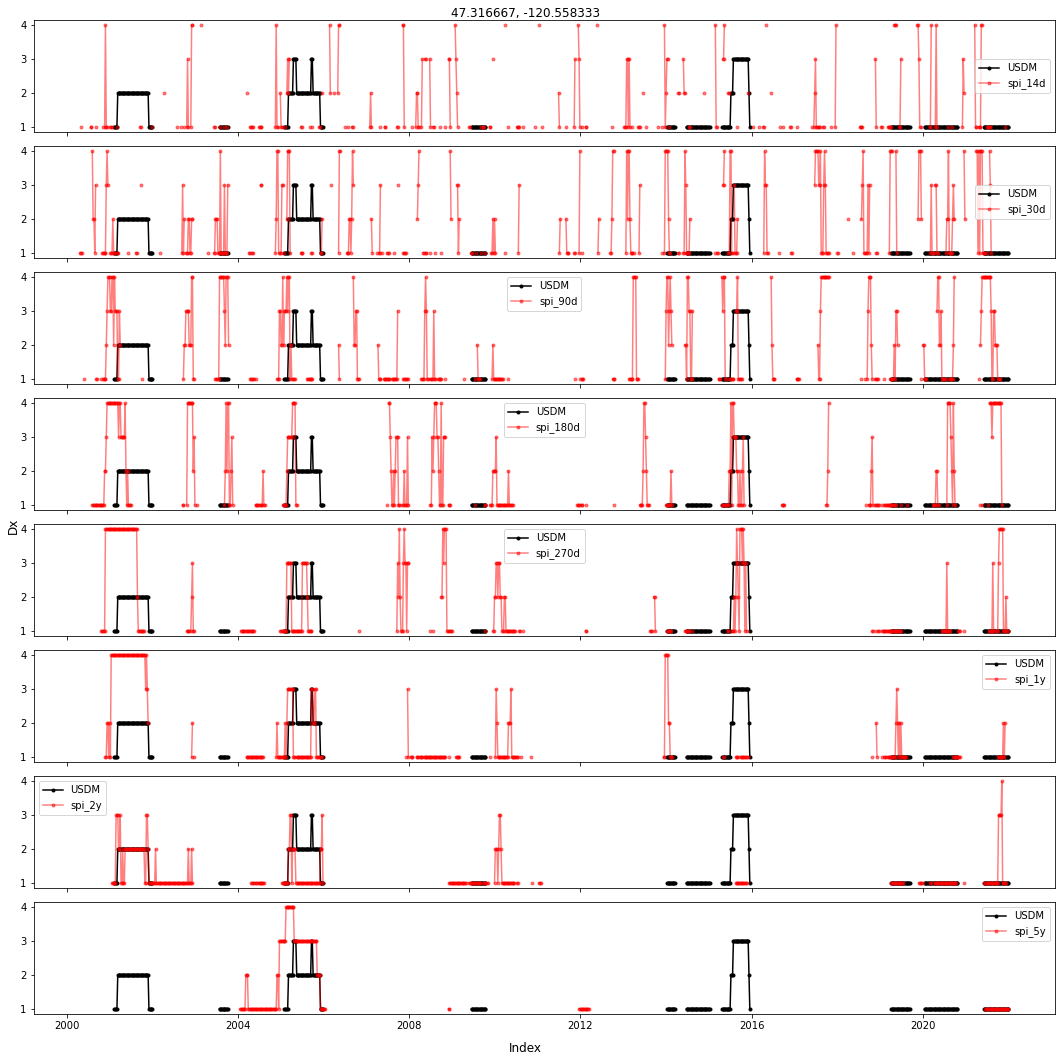

In [22]:
lat_dex = 40
lon_dex = 100

fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(15,15), sharex=True)

paired_pixel = paired_ds.isel(lat=lat_dex, lon=lon_dex)

test_usdm = paired_pixel['USDM'].values.copy()
test_usdm[test_usdm < 1] = np.nan

for ax, spi_int in zip(axs.ravel(), spi_intervals):

    test_spi = paired_pixel[f'spi_{spi_int}'].values.copy()
    test_spi[test_spi < 1] = np.nan

    ax.plot(usdm_dates, test_usdm, color='k', label='USDM', marker='.')
    ax.plot(usdm_dates, test_spi, color='r', label=f'spi_{spi_int}', marker='.', alpha=0.5)
    ax.legend()

fig.suptitle(f'{np.float64(paired_pixel.lat.values):.6f}, {np.float64(paired_pixel.lon.values):.6f}')
fig.supylabel('Dx')
fig.supxlabel('Index')

plt.tight_layout()

Okay, that drastically changes things. What about just greater than D0?

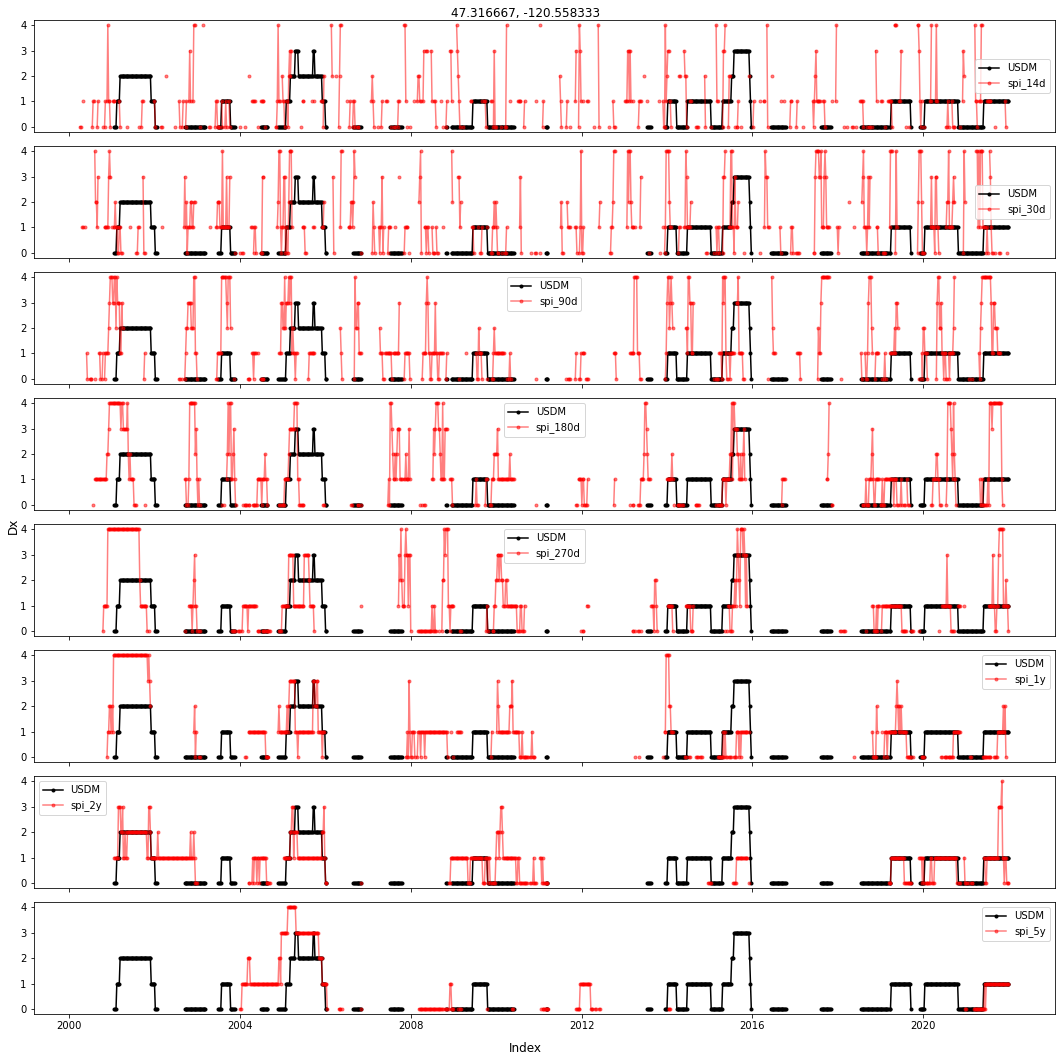

In [23]:
lat_dex = 40
lon_dex = 100

fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(15,15), sharex=True)

paired_pixel = paired_ds.isel(lat=lat_dex, lon=lon_dex)

test_usdm = paired_pixel['USDM'].values.copy()
test_usdm[test_usdm < 0] = np.nan

for ax, spi_int in zip(axs.ravel(), spi_intervals):

    test_spi = paired_pixel[f'spi_{spi_int}'].values.copy()
    test_spi[test_spi < 0] = np.nan

    ax.plot(usdm_dates, test_usdm, color='k', label='USDM', marker='.')
    ax.plot(usdm_dates, test_spi, color='r', label=f'spi_{spi_int}', marker='.', alpha=0.5)
    ax.legend()

fig.suptitle(f'{np.float64(paired_pixel.lat.values):.6f}, {np.float64(paired_pixel.lon.values):.6f}')
fig.supylabel('Dx')
fig.supxlabel('Index')

plt.tight_layout()

Let's recheck autocorrelation.

In [24]:
dm_vars

['USDM',
 'spi_14d',
 'spi_30d',
 'spi_90d',
 'spi_180d',
 'spi_270d',
 'spi_1y',
 'spi_2y',
 'spi_5y']

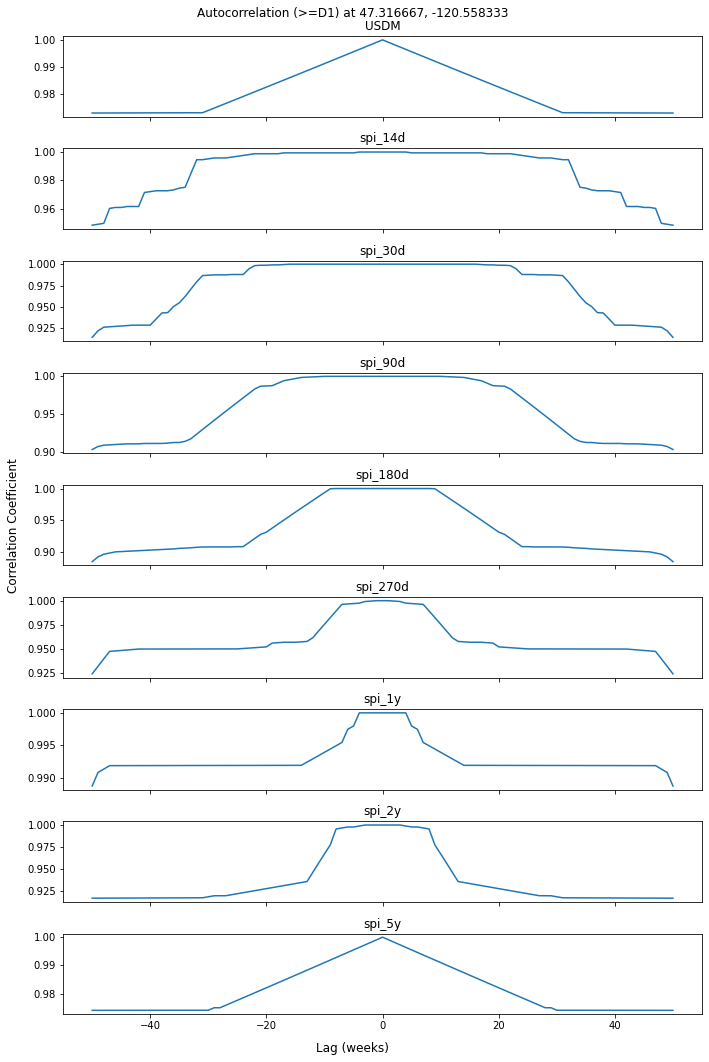

In [25]:
lat_dex = 40
lon_dex = 100

fig, axs = plt.subplots(len(dm_vars), 1, figsize=(10,15), sharex=True)

paired_pixel = paired_ds.isel(lat=lat_dex, lon=lon_dex)

for ax, dm_var in zip(axs.ravel(), dm_vars):

    filtered_pixel = paired_pixel[f'{dm_var}'].copy()
    filtered_pixel[filtered_pixel < 1] = np.nan

    lag, r = lag_nan_corrcoef(filtered_pixel, filtered_pixel, lag=50)

    ax.plot(lag, r)
    ax.set_title(f'{dm_var}')

fig.suptitle(f'Autocorrelation (>=D1) at {np.float64(paired_pixel.lat.values):.6f}, {np.float64(paired_pixel.lon.values):.6f}')
fig.supylabel('Correlation Coefficient')
fig.supxlabel('Lag (weeks)')

plt.tight_layout()

Hm, still quite high. I wonder though if the nans are now getting in the way?

Well let's see how lagged correlation is now ... along with cutting down the window to +/- 20

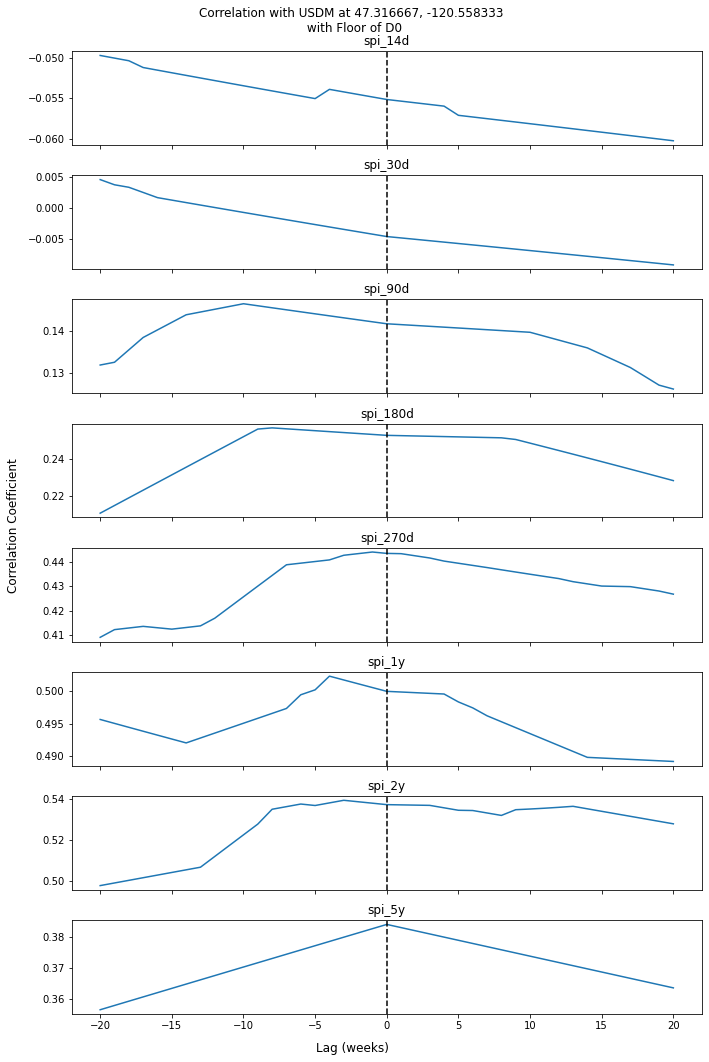

In [26]:
lat_dex = 40
lon_dex = 100

fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(10,15), sharex=True)

paired_pixel = paired_ds.isel(lat=lat_dex, lon=lon_dex)

floor = 0

usdm_filtered = paired_pixel['USDM'].copy()
usdm_filtered[usdm_filtered < floor] = np.nan

for ax, spi_int in zip(axs.ravel(), spi_intervals):

    spi_filtered = paired_pixel[f'spi_{spi_int}'].copy()
    spi_filtered[spi_filtered < floor] = np.nan

    lag, r = lag_nan_corrcoef(usdm_filtered, spi_filtered, lag=20)

    ax.plot(lag, r)
    ax.set_title(f'spi_{spi_int}')
    ax.axvline(0, color='k', linestyle='--')

fig.suptitle(f'Correlation with USDM at {np.float64(paired_pixel.lat.values):.6f}, {np.float64(paired_pixel.lon.values):.6f} \n with Floor of D{floor}')
fig.supylabel('Correlation Coefficient')
fig.supxlabel('Lag (weeks)')

plt.tight_layout()

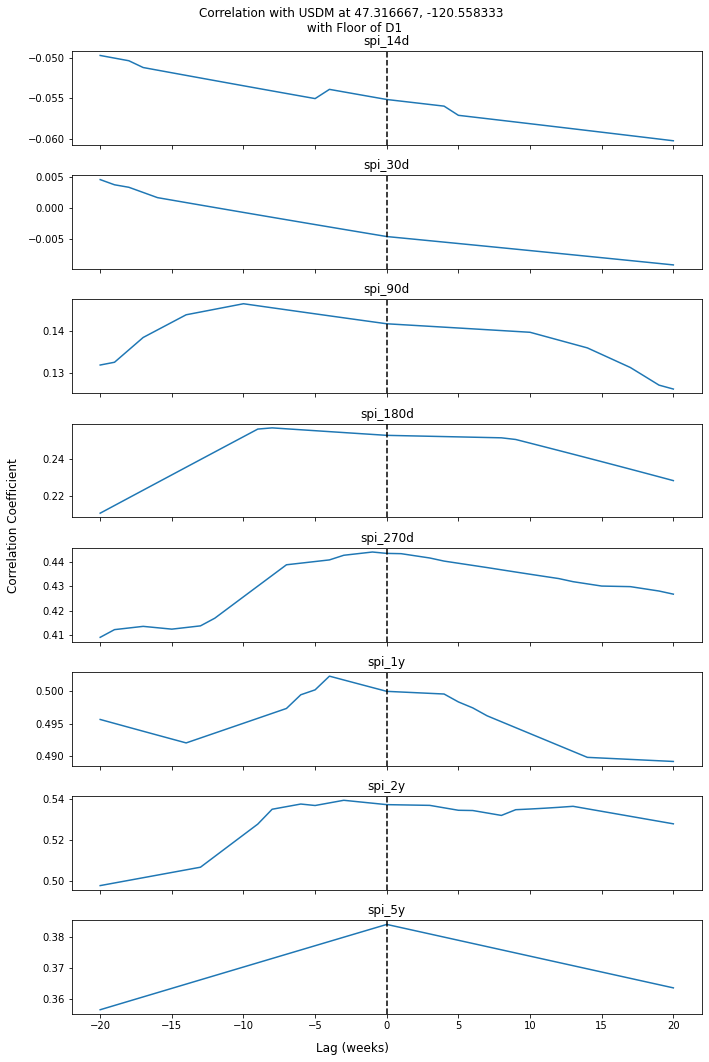

In [27]:
lat_dex = 40
lon_dex = 100

fig, axs = plt.subplots(len(spi_intervals), 1, figsize=(10,15), sharex=True)

paired_pixel = paired_ds.isel(lat=lat_dex, lon=lon_dex)

floor = 1

usdm_filtered = paired_pixel['USDM'].copy()
usdm_filtered[usdm_filtered < floor] = np.nan

for ax, spi_int in zip(axs.ravel(), spi_intervals):

    spi_filtered = paired_pixel[f'spi_{spi_int}'].copy()
    spi_filtered[spi_filtered < floor] = np.nan

    lag, r = lag_nan_corrcoef(usdm_filtered, spi_filtered, lag=20)

    ax.plot(lag, r)
    ax.set_title(f'spi_{spi_int}')
    ax.axvline(0, color='k', linestyle='--')

fig.suptitle(f'Correlation with USDM at {np.float64(paired_pixel.lat.values):.6f}, {np.float64(paired_pixel.lon.values):.6f} \n with Floor of D{floor}')
fig.supylabel('Correlation Coefficient')
fig.supxlabel('Lag (weeks)')

plt.tight_layout()

Okay, I'm curious what this looks like across WA

In [28]:
paired_ds.load()

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 0
    USDM         (index, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    USDM Date    (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2021-12-28
    spi_1y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_2y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_5y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_14d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_30d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_90d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_180d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_270d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    SPI Date     (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-26
Attributes:
    author:       a. stein 6/8/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

Need to speed this up

In [29]:
import multiprocessing as mp

In [30]:
mp.Pool?

Signature:
mp.Pool(
    processes=None,
    initializer=None,
    initargs=(),
    maxtasksperchild=None,
)
Docstring: Returns a process pool object
File:      /pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/multiprocessing/context.py
Type:      method


In [31]:
pool = mp.Pool(processes=30)

In [32]:
pool.map?

Signature: pool.map(func, iterable, chunksize=None)
Docstring:
Apply `func` to each element in `iterable`, collecting the results
in a list that is returned.
File:      /pool0/data/steinadi/.conda/envs/sedi/lib/python3.7/multiprocessing/pool.py
Type:      method


In [33]:
def compute_r(args):
    spi_var, lat, lon, lag, floor = args
    pixel_ds = paired_ds.sel(lat=lat, lon=lon)
    
    pixel_usdm = pixel_ds['USDM'].copy()
    pixel_usdm[pixel_usdm < floor] = np.nan

    pixel_spi = pixel_ds[spi_var].copy()
    pixel_spi[pixel_spi < floor] = np.nan

    __, r_pix = lag_nan_corrcoef(pixel_usdm, pixel_spi, lag=lag)

    pixel_usdm = None
    pixel_spi = None

    return r_pix

double check this works ...

In [35]:
compute_r(['spi_1y', paired_ds.lat.values[50], paired_ds.lon.values[80], 20, 0])

array([0.58515705, 0.5852228 , 0.5852884 , 0.58535387, 0.5854192 ,
       0.5854844 , 0.58554946, 0.58561438, 0.58567917, 0.58574382,
       0.58580835, 0.58587273, 0.58593699, 0.58600111, 0.5860651 ,
       0.58612896, 0.58619268, 0.58625628, 0.58631974, 0.58638308,
       0.58644628, 0.58638308, 0.58631974, 0.58625628, 0.58619268,
       0.58612896, 0.5860651 , 0.58600111, 0.58593699, 0.58587273,
       0.58615862, 0.58644511, 0.58673221, 0.58666788, 0.58660341,
       0.58653881, 0.58647407, 0.5864092 , 0.58634419, 0.58627905,
       0.58621377])

Going to flatten this to help with performance and reshape after

In [36]:
args = []

for lat in paired_ds.lat.values:
    for lon in paired_ds.lon.values:
        args.append(('spi_1y', lat, lon, 20, 0))

args

[('spi_1y', 48.983333333333334, -124.72499996666667, 20, 0),
 ('spi_1y', 48.983333333333334, -124.68333330000002, 20, 0),
 ('spi_1y', 48.983333333333334, -124.64166663333334, 20, 0),
 ('spi_1y', 48.983333333333334, -124.59999996666667, 20, 0),
 ('spi_1y', 48.983333333333334, -124.55833330000002, 20, 0),
 ('spi_1y', 48.983333333333334, -124.51666663333334, 20, 0),
 ('spi_1y', 48.983333333333334, -124.47499996666667, 20, 0),
 ('spi_1y', 48.983333333333334, -124.43333330000002, 20, 0),
 ('spi_1y', 48.983333333333334, -124.39166663333334, 20, 0),
 ('spi_1y', 48.983333333333334, -124.34999996666667, 20, 0),
 ('spi_1y', 48.983333333333334, -124.30833330000002, 20, 0),
 ('spi_1y', 48.983333333333334, -124.26666663333334, 20, 0),
 ('spi_1y', 48.983333333333334, -124.22499996666667, 20, 0),
 ('spi_1y', 48.983333333333334, -124.18333330000002, 20, 0),
 ('spi_1y', 48.983333333333334, -124.14166663333334, 20, 0),
 ('spi_1y', 48.983333333333334, -124.09999996666667, 20, 0),
 ('spi_1y', 48.983333333

In [37]:
len(args)

15792

In [38]:
n = 188
m = 84
n*m

15792

In [40]:
results = pool.map(compute_r, tqdm(args))

  0%|          | 0/15792 [00:00<?, ?it/s]

In [41]:
results

[array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
        nan, nan]),
 array([nan, nan, nan, nan, nan, nan, nan, n

In [42]:
results_reshaped = np.array([results[(i-1)*n:i*n] for i in np.arange(1,m+1)])

In [43]:
np.shape(results_reshaped)

(84, 188, 41)

In [44]:
results_max = np.array([[results_reshaped[i,j,:].max() for j in np.arange(n)] for i in np.arange(m)])

In [45]:
results_max

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

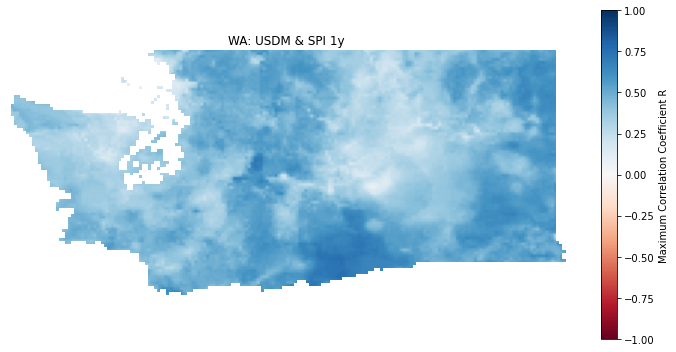

In [50]:
fig, ax = plt.subplots(figsize=(10,5))

plot_max = ax.imshow(results_max, vmin=-1, vmax=1, cmap='RdBu')

fig.colorbar(plot_max, label='Maximum Correlation Coefficient R')
ax.set_title('WA: USDM & SPI 1y')
ax.axis('off')

plt.tight_layout()

In [47]:
results_max_dex = np.array([[np.argmax(results_reshaped[i,j,:]) for j in np.arange(n)] for i in np.arange(m)])
results_max_dex

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

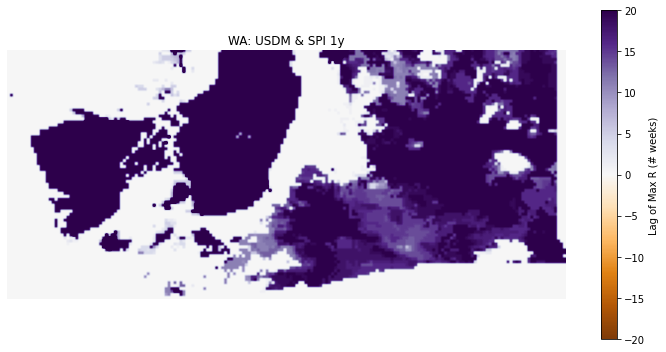

In [51]:
fig, ax = plt.subplots(figsize=(10,5))

plot_max = ax.imshow(results_max_dex, vmin=-20, vmax=20, cmap='PuOr')

fig.colorbar(plot_max, label='Lag of Max R (# weeks)')
ax.set_title('WA: USDM & SPI 1y')
ax.axis('off')

plt.tight_layout()

And now what if I plot the spaghetti? 

Text(0, 0.5, 'Correlation Coefficient')

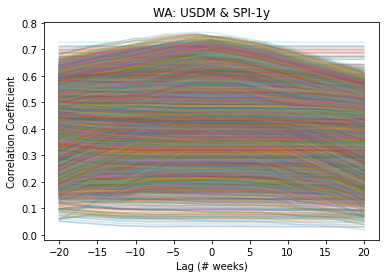

In [53]:
fig, ax = plt.subplots()

lags = np.arange(-20, 21)

for i in np.arange(m):
    for j in np.arange(n):
        ax.plot(lags, results_reshaped[i,j,:], alpha=0.2)

ax.set_title('WA: USDM & SPI-1y')
ax.set_xlabel('Lag (# weeks)')
ax.set_ylabel('Correlation Coefficient')

Well that's just a mess.

Let's get the other time horizons computed.

In [54]:
paired_ds

<xarray.Dataset>
Dimensions:      (lat: 84, lon: 188, index: 1148)
Coordinates:
  * lat          (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon          (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * index        (index) int64 0 1 2 3 4 5 6 ... 1142 1143 1144 1145 1146 1147
Data variables:
    spatial_ref  int64 0
    USDM         (index, lat, lon) float64 nan nan nan nan ... nan nan nan nan
    USDM Date    (index) datetime64[ns] 2000-01-04 2000-01-11 ... 2021-12-28
    spi_1y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_2y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_5y       (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_14d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_30d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_90d      (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_180d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spi_270d     (index, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    SPI Date     (index) datetime64[ns] 1999-12-31 2000-01-10 ... 2021-12-26
Attributes:
    author:       a. stein 6/8/2022
    description:  USDM and SPI matched to USDM data cutoff dates, as describe...
    USDM Date:    this contains the original dates for USDM
    SPI Date:     this contains the original dates for SPI

In [32]:
def compute_r_pixel(args):
   
    # unpack our wrapped arguments
    pixel_x, pixel_y, lag = args

    __, r_pixel = lag_nan_corrcoef(pixel_x, pixel_y, lag=lag)

    return r_pixel

In [40]:
def compute_r_multi_mp(ds:xr.Dataset, pool:mp.Pool, x_vars=list, y_vars=list, lag=20, floor=-1):

    result_ds = xr.Dataset(
        coords=dict(
            lat=(["lat"], ds.lat.values),
            lon=(["lon"], ds.lon.values),
            lag=(["lag"], np.arange(-1*lag, lag+1))
        )
    )

    m = len(result_ds.lat)
    n = len(result_ds.lon)

    for x_var in x_vars:
        for y_var in y_vars:
            args = []
            t = tqdm(total=m*n, desc=f'Prepping {x_var} {y_var}')
            for lat in ds.lat.values:
                for lon in ds.lon.values:

                    pixel_ds = ds.sel(lat=lat, lon=lon).copy()

                    pixel_x = pixel_ds[x_var]
                    pixel_x[pixel_x < floor] = np.nan

                    pixel_y = pixel_ds[y_var]
                    pixel_y[pixel_y < floor] = np.nan

                    args.append((pixel_x, pixel_y, lag))

                    pixel_ds = None
                    pixel_x = None
                    pixel_y = None

                    t.update()

            results = pool.map(compute_r_pixel, tqdm(args, desc=f"Computing {x_var} {y_var} R"))
            print(f"Reshaping and storing {x_var} {y_var}")
            results_reshaped = np.array([results[(i-1)*n:i*n] for i in np.arange(1,m+1)])

            result_ds[f'{x_var}_{y_var}_r'] = (["lat", "lon", "lag"], results_reshaped)

    return result_ds    

In [41]:
usdm_spi1y_r = compute_r_multi_mp(paired_ds, pool, ['USDM'], ['spi_1y'])

Prepping USDM spi_1y:   0%|          | 0/15792 [00:00<?, ?it/s]

Computing USDM spi_1y R:   0%|          | 0/15792 [00:00<?, ?it/s]

Reshaping and storing USDM spi_1y


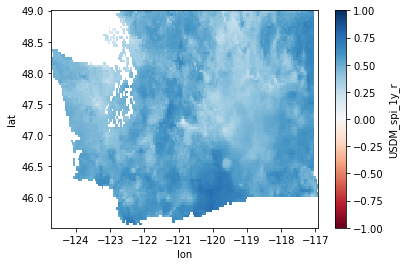

In [48]:
usdm_spi1y_r['USDM_spi_1y_r'].max(dim='lag').plot(vmin=-1, vmax=1, cmap='RdBu')

Cool that looks good, let's get the rest of them

In [50]:
usdm_spi_r = compute_r_multi_mp(paired_ds, pool, ['USDM'], dm_vars[1:])

Prepping USDM spi_14d:   0%|          | 0/15792 [00:00<?, ?it/s]

Computing USDM spi_14d R:   0%|          | 0/15792 [00:00<?, ?it/s]

Reshaping and storing USDM spi_14d


Prepping USDM spi_30d:   0%|          | 0/15792 [00:00<?, ?it/s]

Computing USDM spi_30d R:   0%|          | 0/15792 [00:00<?, ?it/s]

Reshaping and storing USDM spi_30d


Prepping USDM spi_90d:   0%|          | 0/15792 [00:00<?, ?it/s]

Computing USDM spi_90d R:   0%|          | 0/15792 [00:00<?, ?it/s]

Reshaping and storing USDM spi_90d


Prepping USDM spi_180d:   0%|          | 0/15792 [00:00<?, ?it/s]

Computing USDM spi_180d R:   0%|          | 0/15792 [00:00<?, ?it/s]

Reshaping and storing USDM spi_180d


Prepping USDM spi_270d:   0%|          | 0/15792 [00:00<?, ?it/s]

Computing USDM spi_270d R:   0%|          | 0/15792 [00:00<?, ?it/s]

Reshaping and storing USDM spi_270d


Prepping USDM spi_1y:   0%|          | 0/15792 [00:00<?, ?it/s]

Computing USDM spi_1y R:   0%|          | 0/15792 [00:00<?, ?it/s]

Reshaping and storing USDM spi_1y


Prepping USDM spi_2y:   0%|          | 0/15792 [00:00<?, ?it/s]

Computing USDM spi_2y R:   0%|          | 0/15792 [00:00<?, ?it/s]

Reshaping and storing USDM spi_2y


Prepping USDM spi_5y:   0%|          | 0/15792 [00:00<?, ?it/s]

Computing USDM spi_5y R:   0%|          | 0/15792 [00:00<?, ?it/s]

Reshaping and storing USDM spi_5y


In [52]:
usdm_spi_r

<xarray.Dataset>
Dimensions:          (lat: 84, lon: 188, lag: 41)
Coordinates:
  * lat              (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon              (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * lag              (lag) int64 -20 -19 -18 -17 -16 -15 ... 15 16 17 18 19 20
Data variables:
    USDM_spi_14d_r   (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_30d_r   (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_90d_r   (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_180d_r  (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_270d_r  (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_1y_r    (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_2y_r    (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_5y_r    (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan

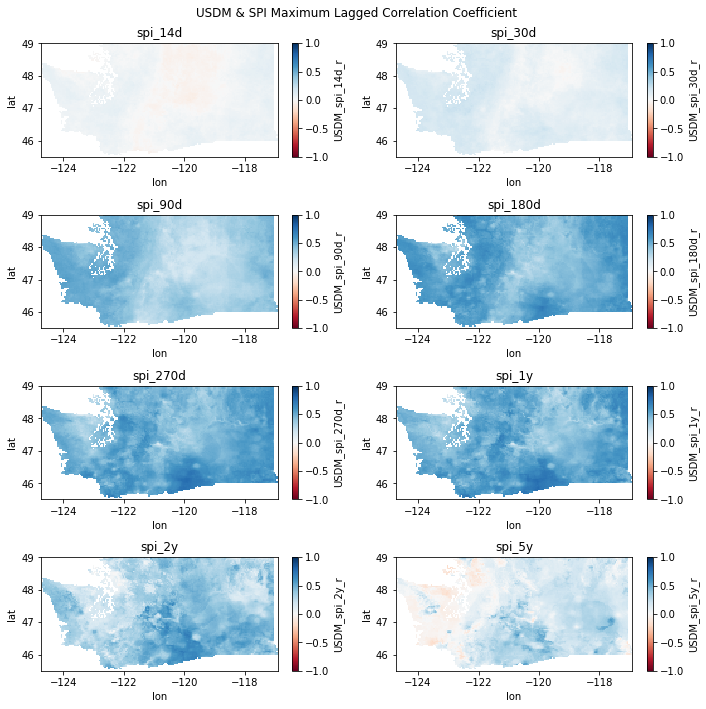

In [72]:
fig, axs = plt.subplots(4, 2, figsize=(10,10))

for ax, spi_int in zip(axs.ravel(), spi_intervals):
    usdm_spi_r[f'USDM_spi_{spi_int}_r'].max(dim='lag').plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu')
    ax.set_title(f'spi_{spi_int}')

fig.suptitle('USDM & SPI Maximum Lagged Correlation Coefficient')

plt.tight_layout()

Cool, I'mma save this out.

In [83]:
usdm_spi_r.attrs = {
    "author":"a. stein",
    "date":"6.9.2022",
    "description":"Correlation coefficients time lagged for up to 20 weeks, where positive lag is USDM leading SPI, computed for each pixel."
}

In [84]:
usdm_spi_r

<xarray.Dataset>
Dimensions:          (lat: 84, lon: 188, lag: 41)
Coordinates:
  * lat              (lat) float64 48.98 48.94 48.9 48.86 ... 45.61 45.57 45.53
  * lon              (lon) float64 -124.7 -124.7 -124.6 ... -117.0 -117.0 -116.9
  * lag              (lag) int64 -20 -19 -18 -17 -16 -15 ... 15 16 17 18 19 20
Data variables:
    USDM_spi_14d_r   (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_30d_r   (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_90d_r   (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_180d_r  (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_270d_r  (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_1y_r    (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_2y_r    (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
    USDM_spi_5y_r    (lat, lon, lag) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    author:       a. stein
    date:         6.9.2022
    description:  Correlation coefficients time lagged for up to 20 weeks, wh...

In [85]:
usdm_spi_r.to_netcdf(f'{dm_path}/ndrought_products/usdm_spi_r_lagged.nc')

Pickup here after everything has ran

In [29]:
usdm_spi_r = xr.open_dataset(f'{dm_path}/ndrought_products/usdm_spi_r_lagged.nc')

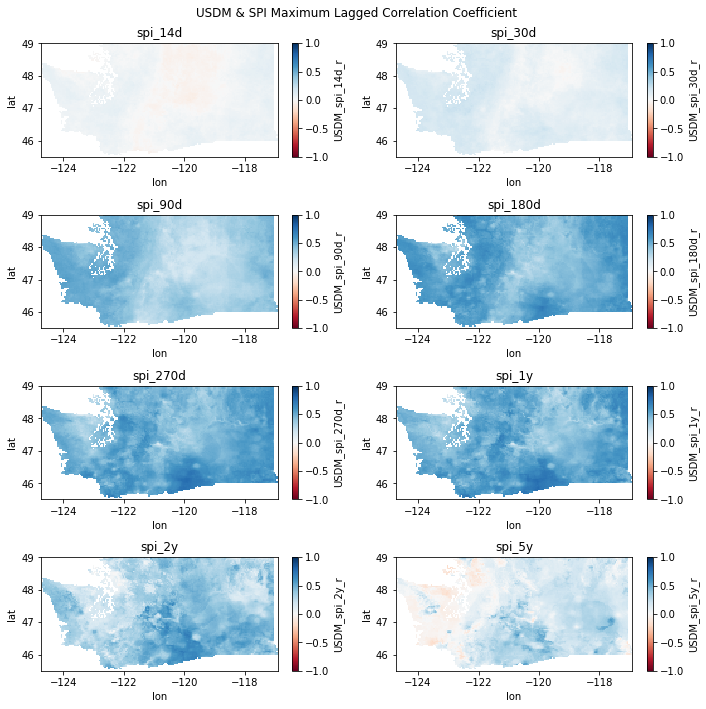

In [30]:
fig, axs = plt.subplots(4, 2, figsize=(10,10))

for ax, spi_int in zip(axs.ravel(), spi_intervals):
    usdm_spi_r[f'USDM_spi_{spi_int}_r'].max(dim='lag').plot(ax=ax, vmin=-1, vmax=1, cmap='RdBu')
    ax.set_title(f'spi_{spi_int}')

fig.suptitle('USDM & SPI Maximum Lagged Correlation Coefficient')

plt.tight_layout()

Now I need to figure out an effective `argmax` that doesn't care about there being nans

AH, can steal this code from earlier

```
results_max_dex = np.array([[np.argmax(results_reshaped[i,j,:]) for j in np.arange(n)] for i in np.arange(m)])
```

In [33]:
m = len(usdm_spi_r.lat)
n = len(usdm_spi_r.lon)

In [34]:
np.array([[np.argmax(usdm_spi_r[f'USDM_spi_90d_r'].values[i, j, :]) for j in np.arange(n)] for i in np.arange(m)])

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

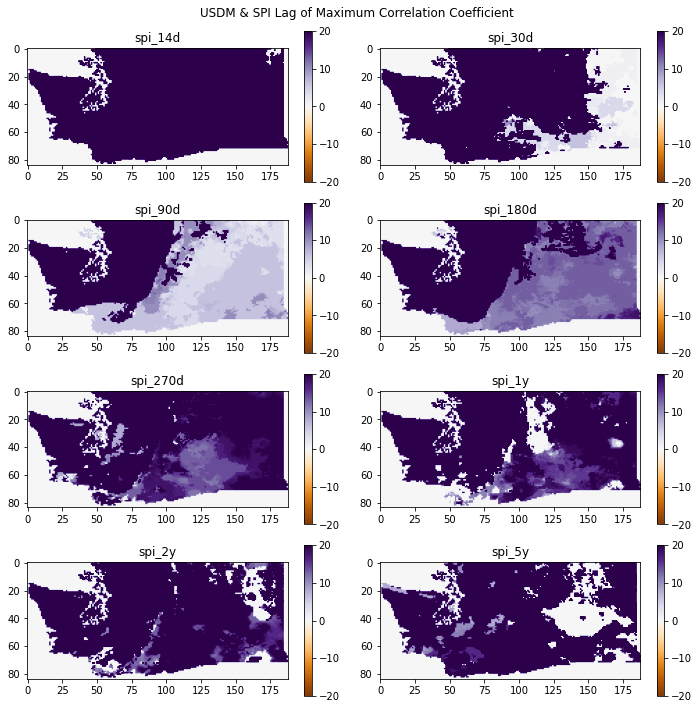

In [38]:
fig, axs = plt.subplots(4, 2, figsize=(10,10))

for ax, spi_int in zip(axs.ravel(), spi_intervals):
    lag_max_r = np.array([[np.argmax(usdm_spi_r[f'USDM_spi_{spi_int}_r'].values[i, j, :]) for j in np.arange(n)] for i in np.arange(m)])
    plotted = ax.imshow(lag_max_r, vmin=-20, vmax=20, cmap='PuOr')
    fig.colorbar(plotted, ax=ax)
    ax.set_title(f'spi_{spi_int}')

fig.suptitle('USDM & SPI Lag of Maximum Correlation Coefficient')

plt.tight_layout()

## Onset / Period

So according to USDM, we are in a drought if at category D1 or higher.

(-1.0, 4.0)

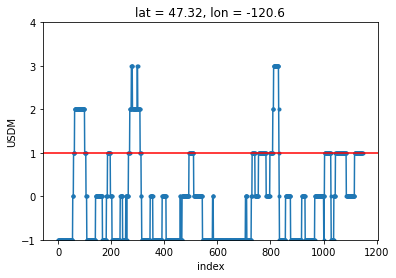

In [53]:
fig, ax = plt.subplots()

test_pixel.plot(ax=ax, marker='.')
ax.axhline(1, color='r')

ax.set_ylim(-1, 4)

In [46]:
onsets = []
ends = []

in_drought = False
for i, val in enumerate(test_pixel.values):
    if val >= 1 and not in_drought:
        in_drought = True
        onsets.append(i)
    if val < 1 and in_drought:
        ends.append(i-1)
        in_drought = False

In [48]:
print(onsets)
print(ends)

[58, 186, 265, 493, 731, 755, 798, 1004, 1045, 1117]
[104, 196, 312, 510, 741, 783, 832, 1027, 1085]


(-1.0, 4.0)

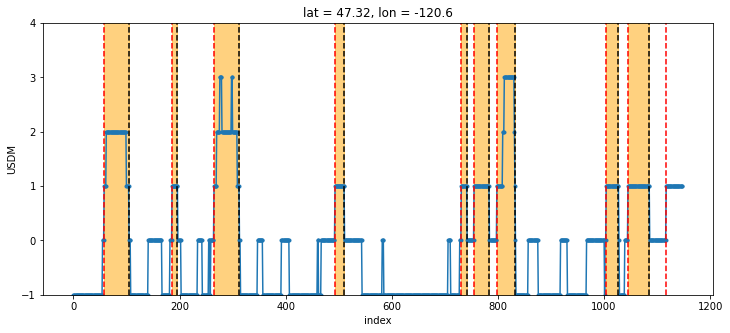

In [66]:
fig, ax = plt.subplots(figsize=(12,5))

test_pixel.plot(ax=ax, marker='.')

for end in ends:
    ax.axvline(end, color='k', linestyle='--')

for onset in onsets:
    ax.axvline(onset, color='r', linestyle='--')

for onset, end in zip(onsets[:-1], ends):
    ax.fill_between([onset, end], [-1, -1], [4, 4], color='orange', alpha = 0.5)

ax.set_ylim(-1, 4)

That's looking pretty good

Let's pick this up next week. Can do some of the following:
- total weeks in drought
- 